In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm

from rl_glue_horde import RLGlueHorde
from horde import BaseHorde
from toy_env_horde import ToyEnvironment
import seaborn as sns
import tiles3 as tc
import scipy.stats as st
import random

ModuleNotFoundError: No module named 'rl_glue_horde'

In [2]:
class MazeTileCoder:
    def __init__(self, iht_size=4096, num_tilings=4, num_tiles=4):
        """
        Initializes the Maze Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.iht_size = iht_size
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        
    def get_observation(self, state):
        return state//10, state%10
    
    def get_tiles(self, state):
        i_scale = self.num_tiles / 5
        j_scale = self.num_tiles / 9
        
        position_i, position_j = self.get_observation(state)
        tiles = tc.tiles(self.iht, self.num_tilings, [(5 - position_i)*i_scale, 
                                                      position_j*j_scale])  
        return np.array(tiles)
    
    def get_state_vector(self, state):
        active_tile = self.get_tiles(state)
        vector = np.zeros(self.iht_size)
        vector[active_tile] = 1
        return vector

In [ ]:
### inherit the abstract class

class Horde(BaseHorde):
    """Implements the agent for an RL-Glue environment.
    Note:
        agent_init, agent_start, agent_step, agent_end, agent_cleanup, and
        agent_message are required methods.
    """

    def horde_init(self, horde_info= {}):
        # Create a random number generator with the provided seed to seed the agent for reproducibility.
        self.rand_generator = np.random.RandomState(horde_info.get("seed"))
        # behaviour policy 
        self.policy = horde_info.get("policy")
        self.valueGVF_number = horde_info.get("valueGVF_number")
        self.actionGVF_number = horde_info.get("actionGVF_number")
        dic = {}
        for j in range(1, self.valueGVF_number + 1):
            name = "V{}".format(j)
            if(horde_info.get(name) != None):
                dic[name] = ValueGVF(horde_info.get(name))
        for j in range(1, self.actionGVF_number + 1):
            name = "A{}".format(j)
            if(horde_info.get(name) != None):
                dic[name] = ActionValueGVF(horde_info.get(name))
        self.GVFs = dic
        """Setup for the agent called when the experiment first starts."""

    def horde_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the environment's env_start function.
        Returns:
            The first action the agent takes. 
        """
        action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
        
        # value gvf
        for j in range(1, self.valueGVF_number + 1):
            name = "V{}".format(j)
            gvf = self.GVFs.get(name)
            if gvf != None:
                gvf.start(state, action)
                self.GVFs.update({name : gvf})
            
        # action value gvf
        for j in range(1, self.actionGVF_number + 1):
            name = "A{}".format(j)
            gvf = self.GVFs.get(name)
            if gvf != None:
                gvf.start(state, action)
                self.GVFs.update({name : gvf})
            
        self.last_state = state
        self.last_action = action

    def horde_step(self, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # value gvf
        action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
        
        for j in range(1, self.valueGVF_number + 1):
            name = "V{}".format(j)
            gvf = self.GVFs.get(name)
            if gvf != None:
                rho = gvf.policy[self.last_state, self.last_action] / self.policy[self.last_state, self.last_action]
                gvf.step(state, rho)
                self.GVFs.update({name : gvf})
            
        # action value gvf    
        for j in range(1, self.actionGVF_number + 1):
            name = "A{}".format(j)
            gvf = self.GVFs.get(name)
            if gvf != None:
                rho = gvf.policy[self.last_state, self.last_action] / self.policy[self.last_state, self.last_action]
                gvf.step(state, action, rho)
                self.GVFs.update({name : gvf})
        
        self.last_state = state
        self.last_action = action
        
        return self.last_action

    def horde_end(self, state):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """
        action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
        
        # value gvf
        for j in range(1, self.valueGVF_number + 1):
            name = "V{}".format(j)
            gvf = self.GVFs.get(name)
            if gvf != None:
                rho = gvf.policy[self.last_state, self.last_action] / self.policy[self.last_state, self.last_action]
                gvf.end(state, rho)
                self.GVFs.update({name : gvf})
            
        # action value gvf    
        for j in range(1, self.actionGVF_number + 1):
            name = "A{}".format(j)
            gvf = self.GVFs.get(name)
            if gvf != None:
                rho = gvf.policy[self.last_state, self.last_action] / self.policy[self.last_state, self.last_action]
                gvf.end(state, action, rho)
                self.GVFs.update({name : gvf})
            
    def horde_cleanup(self):
        """Cleanup done after the agent ends."""

    def horde_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """


In [5]:
def run_experiment(horde_info, 
                   num_episodes=1,
                   plot_freq = 10,
                   value_error_threshold=1e-8):
    
    env = ToyEnvironment
    horde = Horde
    rl_glue = RLGlueHorde(env, horde)

    rl_glue.rl_init(horde_info)

    for episode in range(1, num_episodes + 1):
        rl_glue.rl_episode(0) # no step limit

    values = rl_glue.horde.horde_message("get_values")
    
    return rl_glue, values

In [6]:
class ActionValueGVF:
    def __init__(self, agent_info={}):
        
        ## parameters
        self.lambd = agent_info.get("lambda", 0.1)
        self.alpha = agent_info.get("alpha", 0.1)
        self.beta = agent_info.get("beta", 0.01)
        self.gamma = agent_info.get("gamma", 0.95)
        self.num_actions = agent_info.get("num_actions", 4)
        self.last_gamma = self.gamma
        self.current_gamma = None
        self.last_state = None
        
        ## tile coding
        self.num_tilings = agent_info.get("num_tilings", 4)
        self.num_tiles = agent_info.get("num_tiles", 4)
        
        #self.tc = AlternativeTileCoder(num_tilings=self.num_tilings, 
        # num_tiles=self.num_tiles)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.tc = MazeTileCoder(self.iht_size, self.num_tilings, self.num_tiles)
        ## weights
        self.weights = np.zeros(self.iht_size * self.num_actions)
        self.hWeights = np.zeros(self.iht_size * self.num_actions)
        self.eligTrace = np.zeros(self.iht_size * self.num_actions)
        
        ## objective state
        i,j = agent_info.get("objective_state", [2,4])
        self.objective_state = i*10 + j
        
        ## distrib params
        self.mu = agent_info.get("mu", 10)
        self.sigma = agent_info.get("sigma", 0.001)
        
        self.cumulants = []
        self.gammas = []
        self.returns = []
        self.states = []
        self.actions = []
        self.rhos = []
        self.prodrhos = []
        
        self.control = agent_info.get("control", False)
        if not self.control:
            self.policy = agent_info.get("policy")
        else:
            self.policy = np.ones((60, self.num_actions))/self.num_actions
        self.q_values = np.zeros((60, self.num_actions))
        self.obstacles = [[2,1],[3,1],[4,1],[0,4],[1,4],[5,5],[1,7],[2,7],[2,8],[3,8]]
        
    def set_returns(self):
        n = len(self.cumulants)
        returns = [0]*n
        prod = [0]*n
        for j in range(n-1, -1, -1):
            if j == len(returns) - 1:
                returns[j] = self.cumulants[j]
                prod[j] = self.rhos[j]
            else:
                returns[j] = self.cumulants[j] + self.gammas[j]*returns[j+1]
                if self.gammas[j] == 0:
                    prod[j] = self.rhos[j]
                else:
                    prod[j] = self.rhos[j]*prod[j+1]
                    
        self.rhos = []
        self.gammas = []
        self.cumulants = []
        self.returns.extend(returns)
        self.prodrhos.extend(prod)
    
    def get_vector(self, state, a):
        state_vector = self.tc.get_state_vector(state)
        n = len(state_vector)
        state_action_vector = np.zeros(n*self.num_actions)
        state_action_vector[a*n:(a+1)*n] = state_vector
        return state_action_vector
        
    def transition_gen(self, state):
        ## draw a random sample from a gaussian density when you reach the objective state
        if state == self.objective_state:
            cumulant = st.norm(self.mu, self.sigma).rvs(1)
            gamma = 0
        else:
            cumulant = 0
            gamma = self.gamma
            
        return cumulant, gamma
                
    def update_epsilon_greedy_policy(self, state):
        arg_max = self.argmax(self.q_values[state])
        for action in range(4):
            if (action in arg_max):
                self.policy[state, action] = (1-self.epsilon)/len(arg_max) + self.epsilon/4
            else :
                self.policy[state, action] = self.epsilon/4

    
    def start(self, state, action, rho = 1.0):
        self.last_state = state
        self.last_action = action
    
    def step(self, state, action, rho = 1.0): 
        # get relevant feature
        
        self.states.append(self.last_state)
        self.actions.append(self.last_action)
        self.rhos.append(rho)
        
        cumulant, gamma = self.transition_gen(state)
        self.cumulant = cumulant
        
        self.cumulants.append(float(cumulant))
        self.gammas.append(gamma)
        
        ## retrieve the values
        last_vector = self.get_vector(self.last_state, self.last_action)
        self.last_value = np.sum(self.weights*last_vector)
        
        self.last_gamma = gamma
        self.last_state = state
        self.last_action = action
        
    def end(self, state, action, rho = 1.0): 
        # get relevant feature
        self.states.append(self.last_state)
        self.actions.append(self.last_action)
        self.rhos.append(rho)
        
        cumulant, gamma = self.transition_gen(state)
        self.cumulant = cumulant
        
        self.cumulants.append(float(cumulant))
        self.gammas.append(gamma)
        
        ## retrieve the values
        last_vector = self.get_vector(self.last_state, self.last_action)
        self.last_value = np.sum(self.weights*last_vector)
        ## set the returns of the episode
        self.set_returns()
        
        self.last_gamma = gamma
        
        #self.last_state = state
        #self.last_action = action 

In [23]:
policy = np.ones(shape=(6 * 10, 4)) * 0.25
random.seed(50)
policy_2 = st.dirichlet.rvs(alpha = [1,7,1,1], size = 6*10)
policy_3 = np.zeros((6*10, 4))
policy_3[:,1] = 1

A_info_1 = {
    "control": False,
    "policy": policy,
    "lambda" : 0.1,
    "alpha": 0.1/4,
    "sigma": 2,
    "objective_state" : [2,4], 
    "num_tiles" : 4,
    "num_tilings" : 4}

A_info_2 = {
    "policy": policy,
    "lambda" : 0.1,
    "alpha": 0.1/4,
    "objective_state" : [4,8]}

horde_info = {
    "valueGVF_number" : 0,
    "actionGVF_number" : 1,
    "A1" : A_info_1,
    "policy" : policy
}

In [24]:
def run_experiment(horde_info, 
                   num_episodes=1,
                   plot_freq = 10,
                   value_error_threshold=1e-8):
    
    env = ToyEnvironment
    horde = Horde
    rl_glue = RLGlueHorde(env, horde)

    rl_glue.rl_init(horde_info)

    for episode in range(1, num_episodes + 1):
        rl_glue.rl_episode(0) # no step limit
    
    return rl_glue

In [35]:
rl = run_experiment(horde_info, num_episodes= 20)

In [36]:
gvf = rl.horde.GVFs["A1"]

In [37]:
returns = rl.horde.GVFs["A1"].returns

In [38]:
actions = rl.horde.GVFs["A1"].actions

In [39]:
states = rl.horde.GVFs["A1"].states

In [40]:
rhos = rl.horde.GVFs["A1"].prodrhos

Kernel of the shape $k((s1, a1), (s2, a2)) = \exp(\frac{-\|x_{s1, a1} - x_{s2, a2}\|^2}{\sigma})$

In [41]:
def computeStateActionKernelMatrix(GVF, sigma = 1):
    actions = gvf.actions
    states = gvf.states
    n_ = len(actions)
    p_ = gvf.iht_size*gvf.num_actions
    state_action_features = np.zeros((p_,n_))
    count = 0
    for action, state in zip(actions, states):
        state_action_features[:,count] = GVF.get_vector(state, int(action))
        count +=1
    dotMatrix = np.dot(state_action_features.T, state_action_features)
    v = np.diag(dotMatrix)
    horizonTile = np.tile(v, (len(v), 1))
    distMatrix = horizonTile + horizonTile.T - 2*dotMatrix
    kernelMatrix = np.exp(-distMatrix/sigma)
    return kernelMatrix

In [42]:
kernelMatrix = computeStateActionKernelMatrix(gvf)

In [43]:
def computeBeta(GVF, state, action, sigma = 0.1, reg = 0.001):
    
    ## compute State Action Kernel Matrix
    actions = gvf.actions
    states = gvf.states
    n_ = len(actions)
    p_ = gvf.num_tiles*gvf.num_tilings*gvf.num_actions
    state_action_features = np.zeros((p_,n_))
    count = 0
    for a, s in zip(actions, states):
        i,j = get_observation(s)
        state_action_features[:,count] = GVF.get_vector(i, j, int(a))
        count +=1
    dotMatrix = np.dot(state_action_features.T, state_action_features)
    v = np.diag(dotMatrix)
    horizonTile = np.tile(v, (len(v), 1))
    distMatrix = horizonTile + horizonTile.T - 2*dotMatrix
    kernelMatrix = np.exp(-distMatrix/sigma)
    
    ## compute state_action_feature
    i,j = get_observation(state)
    state_action_feature = GVF.get_vector(i, j, action)
    k_x = v + np.sum(state_action_feature*state_action_feature) - 2*np.dot(state_action_features.T, state_action_feature)
    k_x = np.exp(-k_x/sigma)
    Beta = np.dot(np.linalg.inv(kernelMatrix + n_*reg*np.diag(np.ones(n_))), k_x)
    
    return Beta
    

In [44]:
sigma = 1
reg = 1/len(actions)

In [45]:
## compute State Action Kernel Matrix
actions = gvf.actions
states = gvf.states
n_ = len(actions)
p_ = gvf.iht_size*gvf.num_actions
state_action_features = np.zeros((p_,n_))
count = 0
for a, s in zip(actions, states):
    state_action_features[:,count] = gvf.get_vector(s, int(a))
    count +=1
dotMatrix = np.dot(state_action_features.T, state_action_features)
v = np.diag(dotMatrix)
horizonTile = np.tile(v, (len(v), 1))
distMatrix = horizonTile + horizonTile.T - 2*dotMatrix
kernelMatrix = np.exp(-distMatrix/sigma)
inv = np.linalg.inv(kernelMatrix + n_*reg*np.diag(np.ones(n_)))

In [46]:
q_values = np.zeros((60, 4))

In [47]:
## compute state_action_feature for each state action
for state in range(60):
    for action in range(4):
        state_action_feature = gvf.get_vector(state, action)
        k_x = v + np.sum(state_action_feature*state_action_feature) - 2*np.dot(state_action_features.T, state_action_feature)
        k_x = np.exp(-k_x/sigma)
        Beta = np.dot(inv, k_x)
        q_values[state, action] = np.sum(Beta*returns)

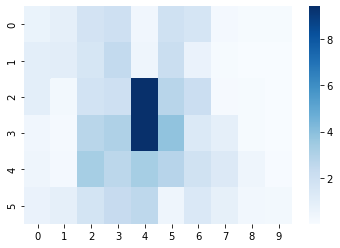

In [48]:
q0 = q_values[:, 0]
q1 = q_values[:, 1]
q2 = q_values[:, 2]
q3 = q_values[:, 3]

h0 = sns.heatmap(q0.reshape(6,10), cmap = "Blues")

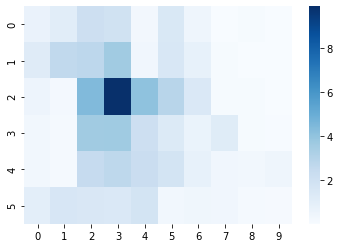

In [49]:
h1 = sns.heatmap(q1.reshape(6,10), cmap = "Blues")

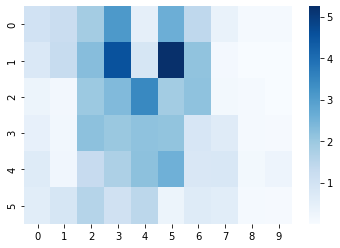

In [50]:
h2 = sns.heatmap(q2.reshape(6,10), cmap = "Blues")

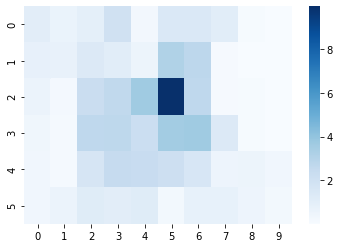

In [51]:
h3 = sns.heatmap(q3.reshape(6,10), cmap = "Blues")

In [612]:
def prod_rhos(rhos):
    n = len(rhos)
    r = [0]*n
    for j in range(n-1, -1, -1):
        if j == len(rhos) - 1:
            r[j] = rhos[j]
        else:
            r[j] = rhos[j]*r[j+1]
        print(r[j])
    return r